In [357]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# load dataset
data = pd.read_csv('Housing.csv')

# spoiler data
print(data.head())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


In [358]:
# konversi kolom categorical jd numerik
data['mainroad'] = data['mainroad'].map({'yes': 1, 'no': 0})
data['guestroom'] = data['guestroom'].map({'yes': 1, 'no': 0})
data['basement'] = data['basement'].map({'yes': 1, 'no': 0})
data['hotwaterheating'] = data['hotwaterheating'].map({'yes': 1, 'no': 0})
data['airconditioning'] = data['airconditioning'].map({'yes': 1, 'no': 0})
data['prefarea'] = data['prefarea'].map({'yes': 1, 'no': 0})
# data['furnishingstatus'] = data['furnishingstatus'].map({'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0})
from sklearn.preprocessing import LabelEncoder
data['furnishingstatus']=LabelEncoder().fit_transform(data['furnishingstatus'])
data.head()

# # Separate features and target
# X = data.drop('price', axis=1)
# y = data['price']

# spoiler dataset
print(data.head())


      price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   
1  12250000  8960         4          4        4         1          0   
2  12250000  9960         3          2        2         1          0   
3  12215000  7500         4          2        2         1          0   
4  11410000  7420         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   furnishingstatus  
0                 0  
1                 0  
2                 1  
3                 0  
4                 0  


In [359]:
def train_test_split(X, y, random_state=32, test_size=0.2):

    n_samples = X.shape[0]
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(np.arange(n_samples))

    test_size = int(n_samples * test_size)

    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

In [360]:
def scale(X):

    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    # normalisasi data
    X = (X - mean) / std
    return X

def scale(y):
    # Calculate the mean and standard deviation of each feature
    mean = np.mean(y, axis=0)
    std = np.std(y, axis=0)

    # normalisasi data
    y = (y - mean) / std
    return y

In [361]:
corr = data.corr()
cor_target = abs(corr["price"])

relevant_features = cor_target[cor_target>0.2]

names = [index for index, value in relevant_features.items()]

names.remove('price')

# Display the results
print(names)
X = data[names].values
y = data['price'].values

X = scale(X)
y = scale(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']


In [362]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache
z = np.linspace(-12, 12, 200)

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    
    return dZ

def linear(Z):
    A = Z  
    cache = Z  
    return A, cache

def linear_backward(dA, cache):
    dZ = dA  
    return dZ

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [363]:
class NeuralNetwork:
    def __init__(self, layer_dimensions=[12, 32, 1], learning_rate=0.01, gd_type='batch', mini_batch_size=64):
        self.layer_dimensions = layer_dimensions
        self.learning_rate = learning_rate
        self.gd_type = gd_type
        self.mini_batch_size = mini_batch_size

        
        
    def initialize_parameters(self):
        np.random.seed(3)
        self.n_layers =  len(self.layer_dimensions)
        for l in range(1, self.n_layers):
            vars(self)[f'W{l}'] = np.random.randn(self.layer_dimensions[l], self.layer_dimensions[l-1]) * 0.01
            vars(self)[f'b{l}'] = np.zeros((self.layer_dimensions[l], 1))

    
    def _linear_forward(self, A, W, b):
    
        Z = np.dot(W,A) + b

        cache = (A, W, b)
        return Z, cache
    
    def _forward_propagation(self,A_prev ,W ,b , activation):
        if activation == "linear":
            Z, linear_cache = self._linear_forward(A_prev, W, b)
            A, activation_cache = linear(Z) 
        elif activation == "relu":
            Z, linear_cache = self._linear_forward(A_prev, W, b) 
            A, activation_cache = relu(Z) 
        cache = (linear_cache, activation_cache)
        return A, cache
    
    
    def forward_propagation(self, X):
    
        caches = []
        A = X
        L =  self.n_layers -1
        for l in range(1, L):
            A_prev = A 
            A, cache = self._forward_propagation(A_prev, vars(self)['W' + str(l)], vars(self)['b' + str(l)], "relu")
            caches.append(cache)
        predictions, cache = self._forward_propagation(A, vars(self)['W' + str(L)], vars(self)['b' + str(L)], "linear")
        caches.append(cache)

        return predictions, caches
        
    def _linear_backward(self, dZ, cache):
    
        A_prev, W, b = cache
        m = A_prev.shape[1]
        dW = (1/m) * np.dot(dZ, A_prev.T)
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T,dZ)
        return dA_prev, dW, db
    
            
    def _back_propagation(self, dA, cache, activation):
    
        linear_cache, activation_cache = cache
        if activation == "relu":
            dZ = relu_backward(dA, activation_cache)

        elif activation == "linear":
            dZ = linear_backward(dA, activation_cache)
        dA_prev, dW, db = self._linear_backward(dZ, linear_cache)
        return dA_prev, dW, db

    def back_propagation(self, predictions, Y, caches):
    
        L =  self.n_layers - 1
        m = predictions.shape[0]
        Y = Y.reshape(predictions.shape) 
        dAL = - (np.divide(Y, predictions+1e-9) - np.divide(1 - Y, 1 - predictions+1e-9))
        current_cache = caches[L-1] 
        vars(self)[f'dA{L-1}'], vars(self)[f'dW{L}'], vars(self)[f'db{L}'] = self._back_propagation(dAL, current_cache, "linear")
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            vars(self)[f'dA{l}'] , vars(self)[f'dW{l+1}'], vars(self)[f'db{l+1}'] = self._back_propagation(vars(self)[f'dA{l + 1}'], current_cache, activation = "relu")
            


    def update_parameters(self):
    
        L = self.n_layers - 1
        for l in range(L):
            vars(self)[f'W{l+1}'] = vars(self)[f'W{l+1}'] - self.learning_rate * vars(self)[f'dW{l+1}']
            vars(self)[f'b{l+1}']  = vars(self)[f'b{l+1}'] - self.learning_rate * vars(self)[f'db{l+1}']
                

    def fit(self, X_train, y_train, X_test=None, y_test=None, epochs=2000, print_cost=True):
       
        X_train = X_train.T  # Transpose X_train to get the correct shape
        if len(y_train.shape) == 1:  # Reshape Y_train if it's 1D
            y_train = y_train.reshape(1, -1)

        np.random.seed(1)
        train_costs_mse = []  # To store training MSE costs
        train_costs_mae = []  # To store training MAE costs
        test_costs_mse = []  # To store testing MSE costs
        test_costs_mae = []  # To store testing MAE costs (if testing data is provided)
        m = X_train.shape[1]  # Number of training examples
        self.initialize_parameters()  # Initialize parameters

        # Gradient Descent Loop
        for i in range(epochs):
            if self.gd_type == 'batch':
                # Batch Gradient Descent
                predictions, caches = self.forward_propagation(X_train)
                train_mse, train_mae = self.compute_cost(predictions, y_train)
                self.back_propagation(predictions, y_train, caches)
                self.update_parameters()

            elif self.gd_type == 'stochastic':
                # Stochastic Gradient Descent
                for j in range(m):  # Loop over all examples
                    x_single = X_train[:, j].reshape(-1, 1)  # Single example (column vector)
                    y_single = y_train[:, j].reshape(1, -1)  # Corresponding label
                    predictions, caches = self.forward_propagation(x_single)
                    train_mse, train_mae = self.compute_cost(predictions, y_single)
                    self.back_propagation(predictions, y_single, caches)
                    self.update_parameters()

            elif self.gd_type == 'minibatch':
                # Mini-batch Gradient Descent
                mini_batches = self.create_mini_batches(X_train, y_train, self.mini_batch_size)
                for mini_batch in mini_batches:
                    (X_mini, Y_mini) = mini_batch
                    predictions, caches = self.forward_propagation(X_mini)
                    train_mse, train_mae = self.compute_cost(predictions, Y_mini)
                    self.back_propagation(predictions, Y_mini, caches)
                    self.update_parameters()

            # Store the training cost (MSE and MAE)
            train_costs_mse.append(train_mse)
            train_costs_mae.append(train_mae)

            # Compute testing cost if testing data is provided
            if X_test is not None and y_test is not None:
                test_predictions, _ = self.forward_propagation(X_test.T)
                test_mse, test_mae = self.compute_cost(test_predictions, y_test.T)
                test_costs_mse.append(test_mse)
                test_costs_mae.append(test_mae)

            # Print the cost every 500 epochs
            if print_cost and i % 500 == 0:
                if X_test is not None and y_test is not None:
                    print(f"Cost after iteration {i}: Train MSE = {train_mse}, Train MAE = {train_mae}, "
                          f"Testing MSE = {test_mse}, Testing MAE = {test_mae}")
                else:
                    print(f"Cost after iteration {i}: Train MSE = {train_mse}, Train MAE = {train_mae}")

        return train_costs_mse, train_costs_mae, test_costs_mse, test_costs_mae



    def create_mini_batches(self, X, Y, mini_batch_size):

        m = X.shape[1]  # Number of examples
        mini_batches = []
        permutation = list(np.random.permutation(m))  # Randomize examples
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation]

        num_complete_minibatches = m // mini_batch_size  # Number of full mini-batches
        for k in range(num_complete_minibatches):
            X_mini = shuffled_X[:, k * mini_batch_size:(k + 1) * mini_batch_size]
            Y_mini = shuffled_Y[:, k * mini_batch_size:(k + 1) * mini_batch_size]
            mini_batches.append((X_mini, Y_mini))

        # Handle the last mini-batch (if size is less than mini_batch_size)
        if m % mini_batch_size != 0:
            X_mini = shuffled_X[:, num_complete_minibatches * mini_batch_size:]
            Y_mini = shuffled_Y[:, num_complete_minibatches * mini_batch_size:]
            mini_batches.append((X_mini, Y_mini))

        return mini_batches            

    def predict(self,X,y):

        X = X.T
        # Get predictions from forward propagation
        predictions, _ = self.forward_propagation(X)
        # Predictions Above 0.5 are True otherwise they are False
        predictions = (predictions > 0.5)
        # Squeeze the predictions into the correct shape and cast true/false values to 1/0
        predictions = np.squeeze(predictions.astype(int))
        #Print the accuracy
        return np.sum((predictions == y)/X.shape[1]), predictions.T
    
    def compute_cost(self, predictions, y):

        m = y.shape[0]  # Change this to 1 for single example

        # Compute MSE
        cost_mse = (1/m) * np.sum((predictions - y) ** 2)

        # Compute MAE
        cost_mae = (1/m) * np.sum(np.abs(predictions - y))

        return cost_mse, cost_mae


In [1]:
def train_and_plot(X_train, y_train, X_test, y_test, learning_rate, layer_dimensions, epochs, gd_type='batch', mini_batch_size="-"):

    model = NeuralNetwork(layer_dimensions=layer_dimensions, learning_rate=learning_rate, gd_type=gd_type, mini_batch_size=mini_batch_size)

    # Train the model and get MSE and MAE losses
    train_mse_losses, train_mae_losses, test_mse_losses, test_mae_losses = model.fit(X_train, y_train, X_test, y_test, epochs=epochs, print_cost=False)


    # # Plot final training and testing cost (MSE and MAE)
    # plt.figure(figsize=(10, 6))
    # plt.plot(train_mse_losses, label='Train MSE Loss')
    # plt.plot(train_mae_losses, label='Train MAE Loss')
    # plt.plot(test_mse_losses, label='Testing MSE Loss', linestyle='--')
    # plt.plot(test_mae_losses, label='Testing MAE Loss', linestyle='--')
    # plt.title(f'Final Train vs Testing Losses (GD_Type={gd_type}, Mini_Batch_Size={mini_batch_size})')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    # Return the final testing dataframe (MSE and MAE)
    eval_data = pd.DataFrame([[learning_rate, layer_dimensions, epochs, gd_type, mini_batch_size, test_mse_losses[-1], np.min(test_mse_losses), test_mae_losses[-1], np.min(test_mae_losses)]],
                            columns=['Learning_Rate', 'Layers', 'Epochs', 'GD_Type:', 'Mini_Batch_Size', 'Final_Test_MSE', 'Best_Test_MSE', 'Final_Test_MAE', 'Best_Test_MAE'])
    
    return eval_data


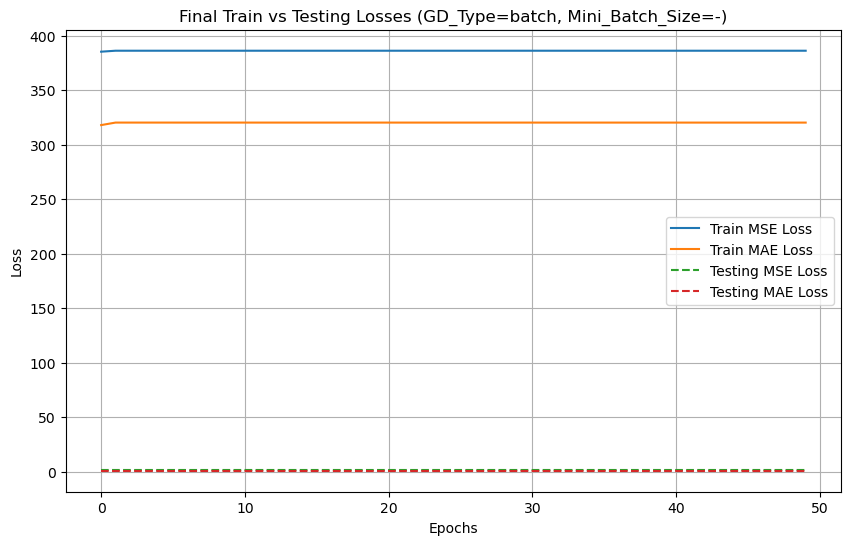

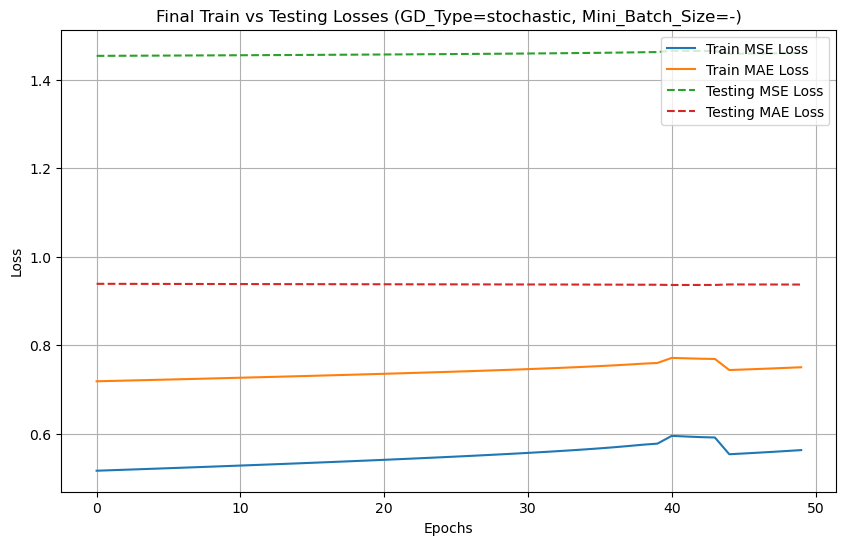

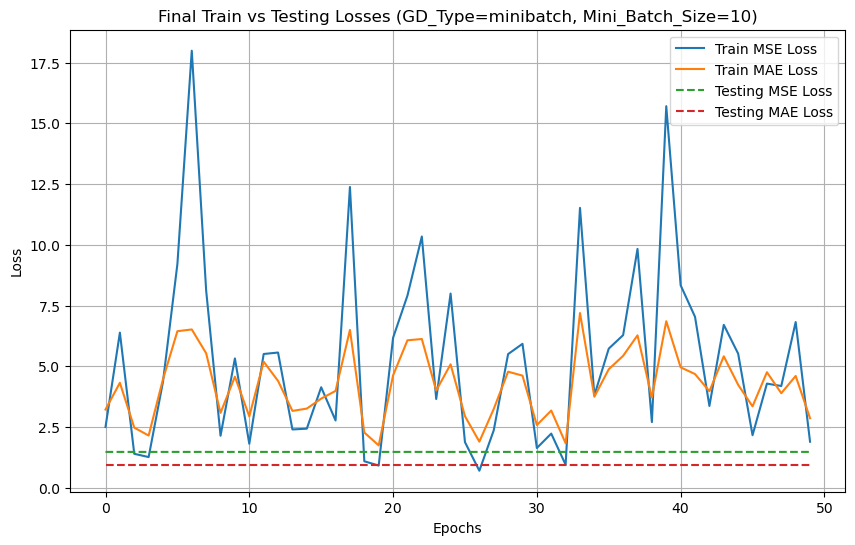

In [365]:
learning_rate = 0.000001
layers = [10, 20, 15, 1]
epochs = 50
# Train using Batch Gradient Descent
results_batch = train_and_plot(X_train, y_train, X_test, y_test, learning_rate, layers, epochs, gd_type='batch')
results_batch.index = ['Batch']

# Train using Stochastic Gradient Descent
results_sgd = train_and_plot(X_train, y_train, X_test, y_test, learning_rate, layers, epochs, gd_type='stochastic')
results_sgd.index = ['SGD']

# Train using Minibatch Gradient Descent
results_minibatch = train_and_plot(X_train, y_train, X_test, y_test, learning_rate, layers, epochs, gd_type='minibatch', mini_batch_size=10)
results_minibatch.index = ['Mini-batch']


In [366]:
# Combine all results into a single DataFrame
final_results = pd.concat([results_batch, results_sgd, results_minibatch], ignore_index=False)

# Apply background gradient styling
styled_results = final_results.style.background_gradient(cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

# Display the final styled results
styled_results

,Learning_Rate,Layers,Epochs,GD_Type:,Mini_Batch_Size,Final_Test_MSE,Best_Test_MSE,Final_Test_MAE,Best_Test_MAE
Batch,0.000001,"[10, 20, 15, 1]",50,batch,-,1.458594,1.458568,0.937815,0.937815
SGD,0.000001,"[10, 20, 15, 1]",50,stochastic,-,1.460634,1.454350,0.937387,0.936412
Mini-batch,0.000001,"[10, 20, 15, 1]",50,minibatch,10,1.479536,1.479273,0.935405,0.935405
